In [31]:
### Segmentacija tumora mozga

In [1]:

import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K


In [2]:
input_dir="New_dataset_sa_maskama/Images/"

target_dir="New_dataset_sa_maskama/Ground-truths/"


train_imgs = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
mask_imgs= sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".jpg") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(train_imgs))

for input_path, target_path in zip(train_imgs[:10], mask_imgs[:10]):
    print(input_path, "|", target_path)

Number of samples: 3064
New_dataset_sa_maskama/Images/0001.jpg | New_dataset_sa_maskama/Ground-truths/0001.jpg
New_dataset_sa_maskama/Images/0002.jpg | New_dataset_sa_maskama/Ground-truths/0002.jpg
New_dataset_sa_maskama/Images/0003.jpg | New_dataset_sa_maskama/Ground-truths/0003.jpg
New_dataset_sa_maskama/Images/0004.jpg | New_dataset_sa_maskama/Ground-truths/0004.jpg
New_dataset_sa_maskama/Images/0005.jpg | New_dataset_sa_maskama/Ground-truths/0005.jpg
New_dataset_sa_maskama/Images/0006.jpg | New_dataset_sa_maskama/Ground-truths/0006.jpg
New_dataset_sa_maskama/Images/0007.jpg | New_dataset_sa_maskama/Ground-truths/0007.jpg
New_dataset_sa_maskama/Images/0008.jpg | New_dataset_sa_maskama/Ground-truths/0008.jpg
New_dataset_sa_maskama/Images/0009.jpg | New_dataset_sa_maskama/Ground-truths/0009.jpg
New_dataset_sa_maskama/Images/0010.jpg | New_dataset_sa_maskama/Ground-truths/0010.jpg


In [3]:
images = [cv2.imread(img, 0) for img in train_imgs]
images=[cv2.resize(img,(224,224)) for img in images]
image_dataset = np.array(images)

image_dataset = np.expand_dims(image_dataset, axis = 3)
image_dataset.shape

(3064, 224, 224, 1)

In [4]:
mask_dataset = [cv2.imread(mask, 0) for mask in mask_imgs]
mask_dataset = [cv2.resize(mask,(224,224)) for mask in mask_dataset]
mask_dataset = [cv2.threshold(mask,127,255,cv2.THRESH_BINARY)[1] for mask in mask_dataset]
mask_dataset = np.array(mask_dataset)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)
mask_dataset.shape

(3064, 224, 224, 1)

In [5]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (3064, 224, 224, 1)
Mask data shape is:  (3064, 224, 224, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [6]:
image_dataset = image_dataset /255.
mask_dataset = mask_dataset /255.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

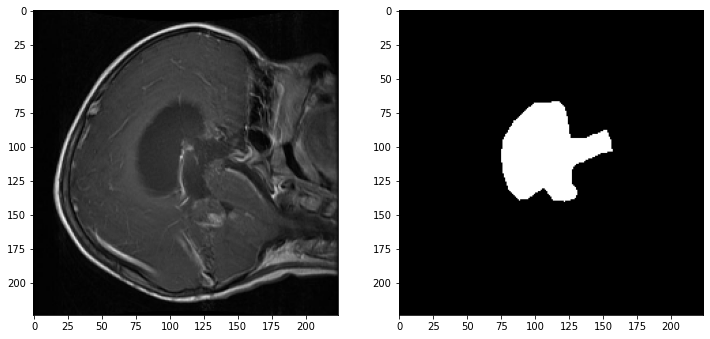

In [8]:
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [9]:
# define jaccard index (IOU)

def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jaccard_coef_loss(y_true, y_pred):
    return -jaccard_coef(y_true, y_pred)

In [10]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512) #Bridge

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)


    outputs = Conv2D(n_classes, 1, padding="same", activation="sigmoid")(d4)  #Change the activation based on n_classes
    

    model = Model(inputs, outputs, name="U-Net")
    return model

In [11]:
input_shape = (224,224,1)
model_jaccard = build_unet(input_shape, n_classes=1)
model_jaccard.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',jaccard_coef])
model_jaccard.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
# Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

model_callbacks = [
             ModelCheckpoint("/content/drive/My Drive/segmentacija_iou101.h5", monitor='val_jaccard_coef', save_best_only=True,mode='max',verbose=1),
             EarlyStopping(monitor='val_jaccard_coef',patience=10,mode='max',verbose=1),
]


In [21]:
history_jaccard = model_jaccard.fit(X_train, y_train, 
                    batch_size = 32, 
                    verbose=1, 
                    epochs=80,
                    callbacks=model_callbacks, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/80
77/77 [==============================] - 84s 1s/step - loss: 0.0032 - accuracy: 0.9986 - jaccard_coef: 0.8883 - val_loss: 0.0303 - val_accuracy: 0.9942 - val_jaccard_coef: 0.6767

Epoch 00001: val_jaccard_coef did not improve from 0.68653
Epoch 2/80
77/77 [==============================] - 83s 1s/step - loss: 0.0030 - accuracy: 0.9987 - jaccard_coef: 0.8935 - val_loss: 0.0322 - val_accuracy: 0.9941 - val_jaccard_coef: 0.6675

Epoch 00002: val_jaccard_coef did not improve from 0.68653
Epoch 3/80
77/77 [==============================] - 83s 1s/step - loss: 0.0029 - accuracy: 0.9988 - jaccard_coef: 0.8987 - val_loss: 0.0327 - val_accuracy: 0.9941 - val_jaccard_coef: 0.6671

Epoch 00003: val_jaccard_coef did not improve from 0.68653
Epoch 4/80
77/77 [==============================] - 83s 1s/step - loss: 0.0029 - accuracy: 0.9987 - jaccard_coef: 0.8984 - val_loss: 0.0307 - val_accuracy: 0.9942 - val_jaccard_coef: 0.6799

Epoch 00004: val_jaccard_coef did not improve from 0.68653


In [ ]:
from tensorflow import keras
model_jaccard.save('segmentacija_model_sa_mean_iou.h5')


In [12]:
model_jaccard.load_weights("segmentacija_iou101.h5")

In [13]:
acc = model_jaccard.evaluate(X_test, y_test)
print("iou of model is = ", (acc[2] * 100.0), "%")
print("loss: ",(acc[0] * 100.0), "%")
print("accuracy: ",(acc[1] * 100.0), "%")


20/20 [==============================] - 342s 17s/step - loss: 0.0318 - accuracy: 0.9944 - jaccard_coef: 0.6941
iou of model is =  69.41171288490295 %
loss:  3.1842589378356934 %
accuracy:  99.43535923957825 %


In [14]:
#IOU
y_pred=model_jaccard.predict(X_test)
y_pred_thresholded = y_pred > 0.5

from tensorflow.keras.metrics import MeanIoU

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())


Mean IoU = 0.8482648


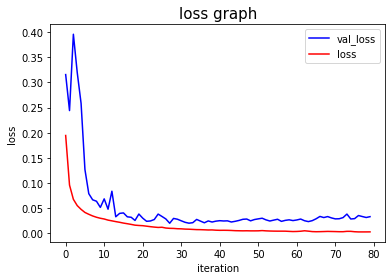

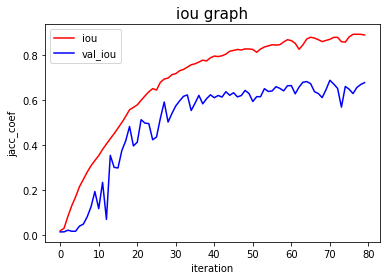

In [13]:
a = history_jaccard.history

list_trainjaccard = a['jaccard_coef']
list_testjaccard = a['val_jaccard_coef']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-',label='val_loss')
plt.plot(list_trainloss,'r-',label='loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.legend()
plt.figure(2)
plt.plot(list_trainjaccard, 'r-',label='iou')
plt.plot(list_testjaccard, 'b-',label='val_iou')
plt.xlabel('iteration')
plt.ylabel('jacc_coef')
plt.title('iou graph', fontsize = 15)
plt.legend()
plt.show()

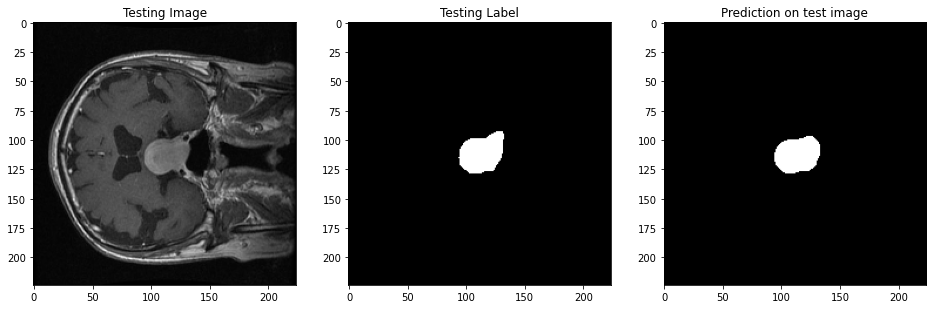

In [16]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model_jaccard.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)


plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(132)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(133)
plt.title('Prediction on test image')
plt.imshow(prediction,cmap='gray')


In [17]:
def plot_test_res(n_res=5):
    
    for i in range(n_res):
        
        test_img_number = random.randint(0, len(X_test))
        test_img = X_test[test_img_number]
        ground_truth=y_test[test_img_number]
        test_img_norm=test_img[:,:,0][:,:,None]
        test_img_input=np.expand_dims(test_img_norm, 0)
        prediction = (model_jaccard.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

        
        plt.figure(figsize=(11,13))
        plt.subplot(1,3,1)
        plt.imshow(np.squeeze(test_img[:,:,0]),cmap='gray')
        plt.title("Test Image")
        plt.subplot(1,3,2)
        plt.imshow(np.squeeze(ground_truth[:,:,0]),cmap='gray')
        plt.title("Test Image Mask")
        plt.subplot(1,3,3)
        plt.imshow(np.squeeze(prediction),cmap='gray')
        plt.title("Predicted Mask")
        plt.show()

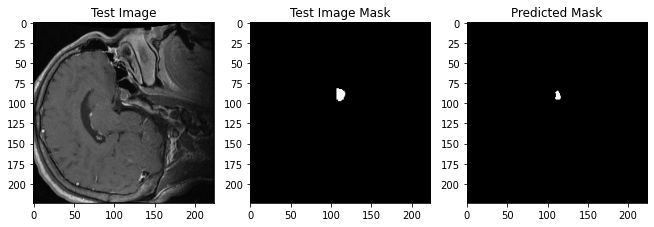

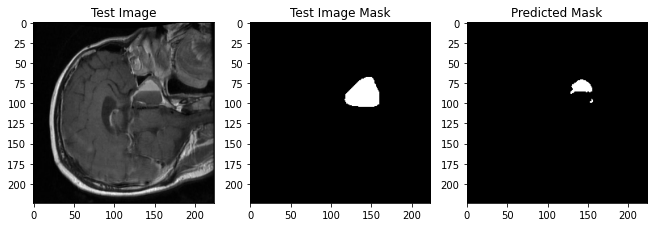

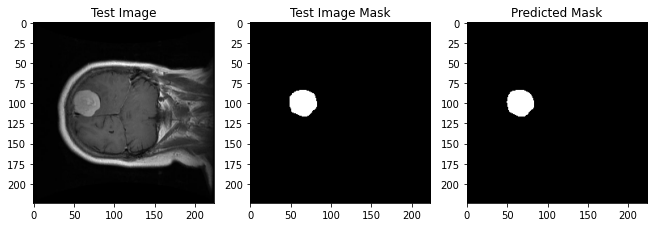

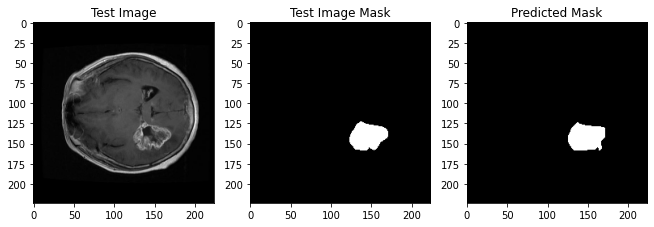

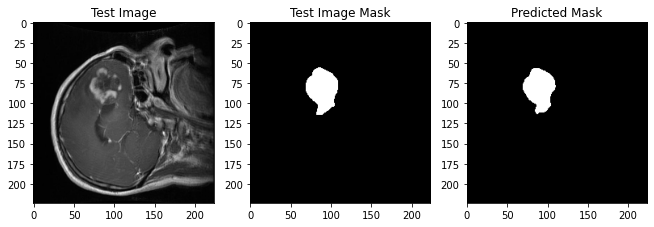

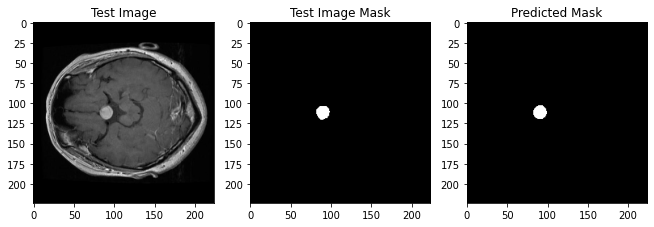

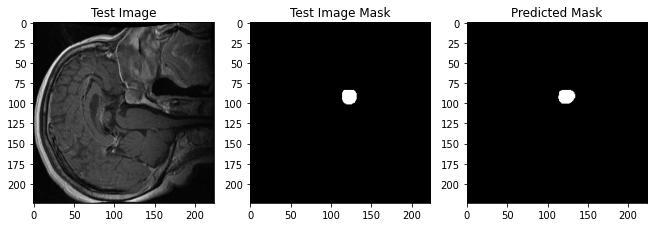

In [19]:
plot_test_res(n_res=7)

Text(0.5, 1.0, 'Brain MRI with mask')

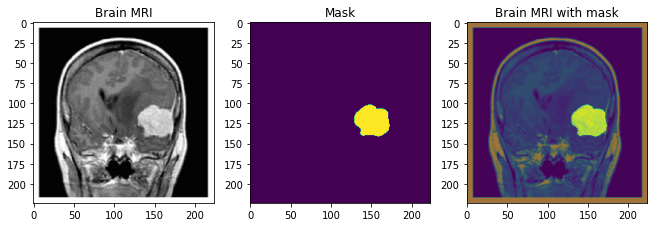

In [20]:
img = cv2.imread("C:/Users/User/Desktop/tomi/AI-umjetna inteligencija/Zavrsni projekt_korisne stvari/dataset za projekt mozak/4_klase_brainMRI_dataset/Test/meningioma_tumor/image(123).jpg",0)
img = cv2.resize(img, (224,224))
img1=np.array(img)
img1 = np.expand_dims(img1, axis = (0,3))  # add dimension before and after (1,192,192,1)
img1 = img1/255
prediction = model_jaccard.predict(img1)
pred = prediction> 0.65

fig, axis = plt.subplots(1,3, figsize=[11,13])

axis[0].imshow(img, cmap='gray')
axis[0].set_title("Brain MRI")

axis[1].imshow(np.squeeze(pred))
axis[1].set_title("Mask")

axis[2].imshow(img)
axis[2].imshow(np.squeeze(pred), alpha = 0.5)
axis[2].grid(False)
axis[2].set_title("Brain MRI with mask")